In [23]:
import numpy as np
import pandas as pd

import emcee
import corner

import os
CWD = "/".join(os.getcwd().split("/")[:-2])

import matplotlib.pyplot as plt
%matplotlib inline

from funcs.model import full_model, aflare, calculate_angular_radius

import astropy.units as u
from astropy.constants import R_sun

import matplotlib 
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 

font = {'family' : 'courier',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

In [24]:
ID = 100004076#230120143#237880881##212035340 #230120143#
tstamp = "20_02_2020_12_04"#'13_12_2019_10_18'#'27_01_2020_12_28'#

In [25]:
inits = pd.read_csv(f"{CWD}/data/summary/inits.csv")
inits = inits[(inits.ID == str(ID))&(inits.tstamp==tstamp)].iloc[0]
qlum = inits.qlum_erg_s *u.erg/u.s
Fth = inits.Fth * u.erg/u.cm**2/u.s
median = inits.median

In [26]:
props = pd.read_csv(f"{CWD}/data/summary/everything.csv")
target = props[props.ID == ID].iloc[0]
R = target.rad * R_sun

In [27]:
R

<Quantity 75258043.2 m>

In [28]:
lc = pd.read_csv(f"{CWD}/data/lcs/{tstamp}_{ID}.csv")

In [29]:
target

ID                             100004076
QCS                                   14
typ                                  slc
cadence_min                            1
mission                              kep
prefix                               KIC
origin                           generic
h_mission                         Kepler
SpT                                   L1
view_start                        1356.5
view_stop                           1361
view_min                             600
view_max                            1050
BJDoff                           2454833
tstart                           1358.55
ampl_min                             NaN
ampl_max                             NaN
RA                                 286.7
Dec                              40.1857
J                                 13.078
R                                    NaN
Gaia_G                           17.8356
vsini_kms                           11.2
e_vsini_kms                          2.2
Prot_d          

In [30]:
# see here https://emcee.readthedocs.io/en/stable/tutorials/monitor/
filename = f"{CWD}/analysis/results/mcmc/{tstamp}_{target.ID}_MCMC.h5"
reader = emcee.backends.HDFBackend(filename)

#tau = reader.get_autocorr_time()
#burnin = int(2 * np.max(tau))
#thin = int(0.5 * np.min(tau))
burnin=10000
thin=15
ndim=6
samples = reader.get_chain(discard=burnin, flat=True, thin=thin)
log_prob_samples = reader.get_log_prob(discard=burnin, flat=True, thin=thin)
log_prior_samples = reader.get_blobs(discard=burnin, flat=True, thin=thin)

print("burn-in: {0}".format(burnin))
print("thin: {0}".format(thin))
print("flat chain shape: {0}".format(samples.shape))
print("flat log prob shape: {0}".format(log_prob_samples.shape))


burn-in: 10000
thin: 15
flat chain shape: (29920, 6)
flat log prob shape: (29920,)


In [31]:

#map phi_a_distr to t0_distr:
samples[:, 0] = np.interp(samples[:,0],lc.phi,lc.t)

# convert theta_f to degrees
samples[:, 1] = samples[:, 1] / np.pi * 180.

# convert FWHM to days
samples[:, 3] = samples[:, 3]/2/np.pi*target.Prot_d 

# convert i to degrees
samples[:, -2] = samples[:, -2] / np.pi * 180.

# map phi0 to phi_peak longitude, still call it phi0
samples[:, -1] = (samples[:, 0]%(2.*np.pi) - samples[:, -1]) / np.pi * 180. # 0 would be facing the observer




# Plots
### Plot the full chain

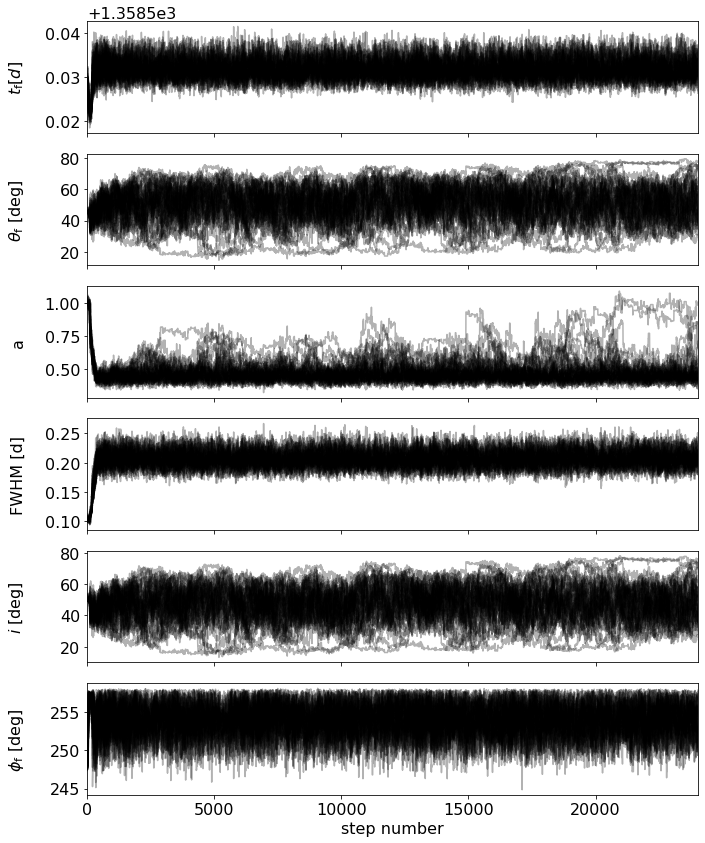

In [32]:
fig, axes = plt.subplots(6, figsize=(10, 12), sharex=True)

multi_samples = reader.get_chain()
walkers = multi_samples.shape[1]
steps = multi_samples.shape[0]
nparam = multi_samples.shape[2]
# -----------------------------------------------------------------------
#map phi_a_distr to t0_distr:
multi_samples[:, :, 0] = np.interp(multi_samples[:,:,0],lc.phi,lc.t)

# convert theta to degrees
multi_samples[:, :, 1] = multi_samples[:,:, 1] / np.pi * 180.

# map phi0 to phi_peak longitude, still call it phi0
multi_samples[:, :,-1] = (multi_samples[:,:,0]%(2.*np.pi) - multi_samples[:,:, -1]) / np.pi * 180.  # 0 would be facing the observer

# convert FWHM to days
multi_samples[:, :, 3] = multi_samples[:,:,3]/2/np.pi*target.Prot_d 

# convert i to degrees
multi_samples[:, :, -2] = multi_samples[:,:, -2] / np.pi * 180.
# -----------------------------------------------------------------------
labels = [r'$t_\mathrm{f} [d]$', r'$\theta_\mathrm{f}$ [deg]', 
          'a', 'FWHM [d]', r'$i$ [deg]',
          r"$\phi_\mathrm{f}$ [deg]"]
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12) 
for j in range(ndim):
    ax = axes[j]
    ax.plot(multi_samples[:, :, j], "k", alpha=0.3)
    ax.set_xlim(0, len(multi_samples))
    ax.set_ylabel(labels[j])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.tight_layout()
plt.savefig(f"{CWD}/analysis/plots/flarefit/{tstamp}_{target.prefix}{target.ID}_chain.png",dpi=300)

### Corner plot

(29920, 6)


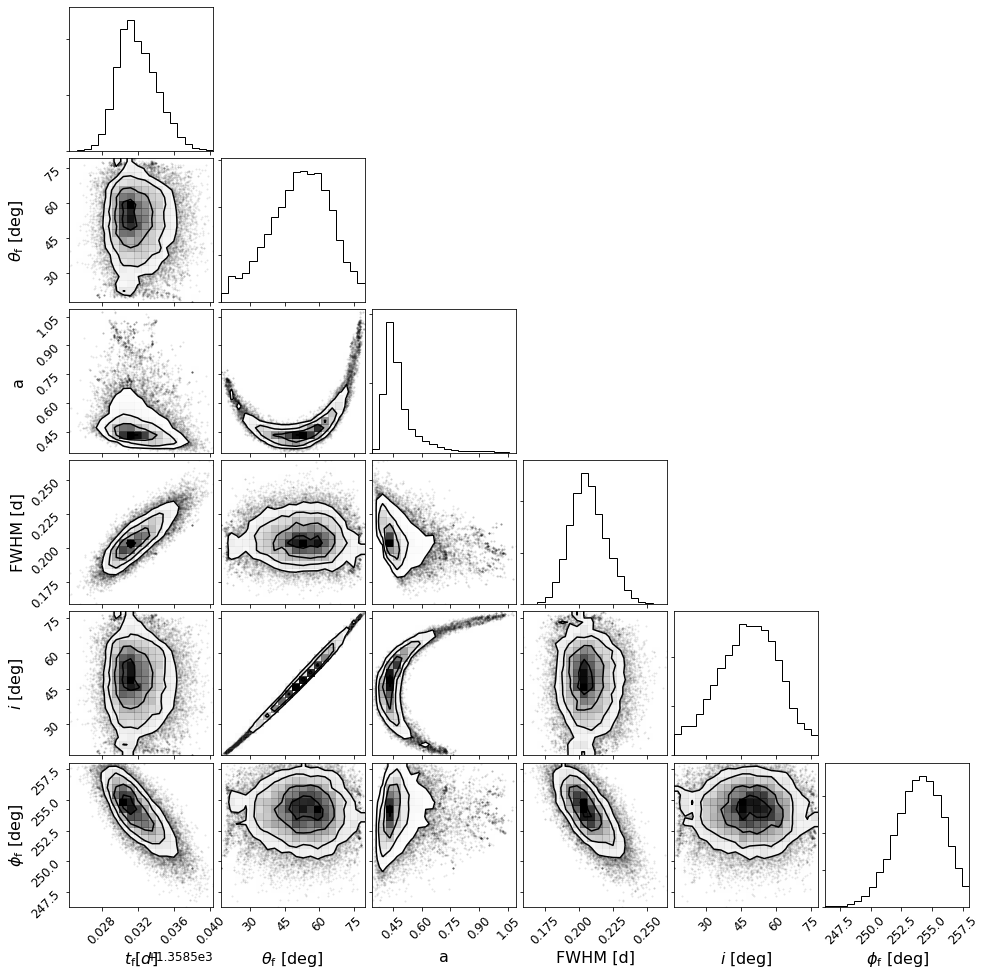

In [33]:

print(samples.shape)
fig = corner.corner(samples, labels=labels)# truths=[phi_a, theta_a, a, fwhm,i_mu, phi0]);
matplotlib.rc('xtick', labelsize=16) 
matplotlib.rc('ytick', labelsize=16) 
plt.savefig(f"{CWD}/analysis/plots/flarefit/{tstamp}_{target.prefix}{target.ID}_corner_disc{burnin}.png",dpi=300)

### Retrieve and plot some example fits to the data from the chain

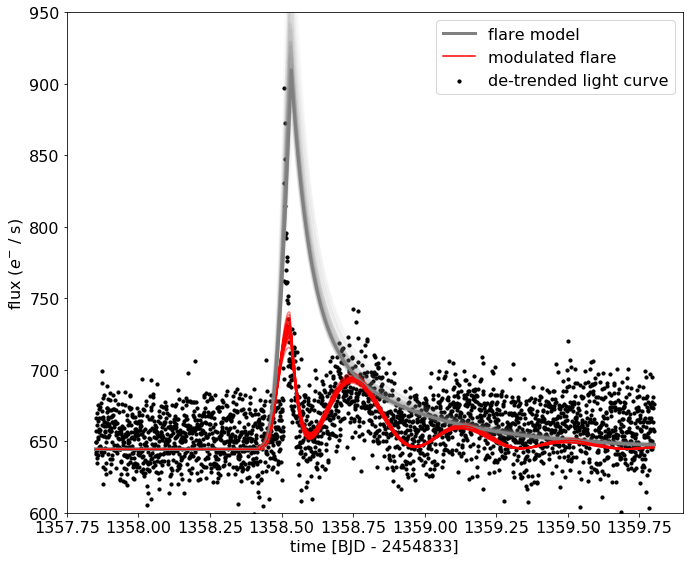

In [34]:
samples2 = reader.get_chain(discard=burnin, flat=True, thin=thin)
N = 50
time = lc.t
phi = lc.phi.values
flux = lc.flux.values
median = lc.median_[0]
#inds = np.rint(np.linspace(len(samples2)-6, 40)).astype(int) - KIC100

inds = np.random.randint(len(samples2), size=N)
plt.figure(figsize=(10,8))
#plt.scatter(flck.time, flck.flux, s=1)
plt.scatter(time, flux, s=10, c="k",label=r"de-trended light curve")
#plt.errorbar(phi, flux, yerr=flux_err, fmt=".k", capsize=0)

for ind in inds:
    sample = samples2[ind]
    phi_a, theta_a, a, fwhm, i, phi0 = sample

    plt.plot(time, aflare(phi, phi_a, fwhm, a*median)+ median, c="grey", alpha=0.05, linewidth=3)
    plt.plot(time, full_model(phi_a, theta_a, a, fwhm, i, phi0=phi0,
               phi=phi, num_pts=50, qlum=qlum,
               Fth=Fth, R=R, median=median), c="r", alpha=0.5)
    
plt.plot(time, aflare(phi, phi_a, fwhm, a*median)+ median, c="grey", alpha=1, linewidth=3,label="flare model")
plt.plot(time, full_model(phi_a, theta_a, a, fwhm, i, phi0=phi0,
               phi=phi, num_pts=50, qlum=qlum,
               Fth=Fth, R=R, median=median), c="r", alpha=1,label="modulated flare")
#plt.plot(phi, flare+median, c="r",linewidth=1)
plt.legend(fontsize=16)
plt.xlabel(f"time [BJD - {target.BJDoff}]",fontsize=16)
plt.ylabel(r"flux ($e^{-}$ / s)",fontsize=16);
#plt.yscale("log")
plt.tight_layout()
plt.ylim(600,950)
#plt.ylim(2000,2500)
#plt.ylim(2300,2500)
#plt.xlim(1358.2,1359.5)
plt.savefig(f"{CWD}/analysis/plots/flarefit/{tstamp}_{target.prefix}{target.ID}_flarefit_{N}retrievals.png",dpi=300)

# Results

### What are the most likely angular radii of the active region?

In [57]:
percentiles = [16,50,84]

In [58]:
rads=[]
for a in samples[:,2]:
#func = np.vectorize(calculate_angular_radius)#(Fth, flat_samples[:,2], qlum, R, 0, 0, np.pi/2, phi0=0)
    rads.append(calculate_angular_radius(Fth, a, qlum, R))


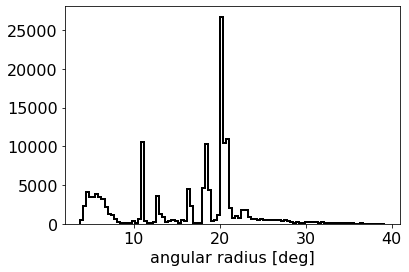

In [59]:
plt.hist(rads,bins=100, histtype="step",color="k",linewidth=2);
plt.xlabel("angular radius [deg]")
radius_p = np.percentile(rads, percentiles, axis=0)
radius_p
plt.savefig(f"{CWD}/analysis/plots/flarefit/{tstamp}_{target.prefix}{target.ID}_active_region_radii.png",dpi=300)

### Equivalent duration distribution

In [60]:
def calculate_ED(t, t0, dur, ampl):
    return np.sum(np.diff(t) * aflare(t, t0, dur, ampl)[:-1]) * 60.0 * 60.0 * 24.0

In [61]:
t0_distr = samples[:,0]
a_distr = samples[:,2]
fwhm_distr = samples[:,3]
l=len(t0_distr)
print(np.mean(t0_distr),np.mean(fwhm_distr),np.median(a_distr))
ED_distr = []
for i in range(l):
    ED_distr.append(calculate_ED(lc.t.values, t0_distr[i], fwhm_distr[i], a_distr[i]))
    #print(lc.t.values, t0_distr[i], fwhm_distr[i], a_distr[i]*median, median )

1358.5091007391018 0.03972791845714371 14.708222005914847


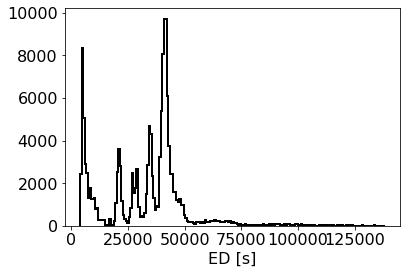

In [62]:
ED_distr = np.array(ED_distr)
ED_distr_p = np.percentile(ED_distr, percentiles, axis=0)
plt.hist(ED_distr,bins=200, histtype="step",color="k",linewidth=2);
plt.xlabel("ED [s]")
plt.savefig(f"{CWD}/analysis/plots/flarefit/{tstamp}_{target.prefix}{target.ID}_flare_ED.png",dpi=300)

### Write percentiles of fitted parameters to table

In [63]:

t0_p, theta_a_p, a_p, fwhm_p, i_p, phi0_p = map(lambda v: (v[0], v[1], v[2]),
                                                   zip(*np.percentile(samples, percentiles,
                                                       axis=0)))


with open(f"{CWD}/analysis/results/mcmc/mcmcoutput.csv","a") as f:
    #Add more lines here
    
    out = f"{tstamp},{target.ID},{burnin},{steps},{walkers},{nparam},"
    firstout = f"date,ID,burnin,steps,walkers,nparam,"
    for i in ['t0_p', 'theta_a_p', 'a_p', 'fwhm_p', 'i_p', 'phi0_p', 'radius_p', 'ED_distr_p', 'Eflare_p']:
        firstout += f"{i}{percentiles[0]},{i}{percentiles[1]},{i}{percentiles[2]},"
    for i in [t0_p, theta_a_p, a_p, fwhm_p, i_p, phi0_p, radius_p, ED_distr_p, (ED_distr_p*qlum).value ]:
        out += f"{i[0]},{i[1]},{i[2]},"
    out += "\n"
    firstout += "\n"
    f.write(firstout)
    f.write(out)